<a href="https://colab.research.google.com/github/Valerie-Perea/data_science_projects_vp/blob/main/VP_Spotify_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


### This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



## Business Problem

This is a supervised learning problem using a Random Forest Regression Model

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [222]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
df = pd.read_csv(url)

print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())

Original shape: (1556, 23)
Columns: ['Index', 'Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Song Name', 'Streams', 'Artist', 'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted', 'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord']


## EDA

In [223]:
# Convert target to numeric
y = pd.to_numeric(df['Popularity'], errors='coerce')
print("Any NaNs in y:", y.isnull().sum())

Any NaNs in y: 11


In [224]:
features = [
    'Highest Charting Position', 'Number of Times Charted', 'Streams',
    'Artist Followers', 'Weeks Charted', 'Danceability', 'Energy', 'Loudness', 'Genre',
    'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence'
]
X_raw = df[features].copy()


### Dropping rows where there are Nulls

In [225]:
# Drop rows where y is NaN
mask = ~y.isnull()
X_raw = X_raw.loc[mask]
y = y.loc[mask]

print("After dropping NaNs in y:")
print("X_raw shape:", X_raw.shape)
print("y shape:", y.shape)

After dropping NaNs in y:
X_raw shape: (1545, 15)
y shape: (1545,)


In [226]:
# After dropping NaNs from y, rebuild X_raw
features = [
    'Highest Charting Position', 'Number of Times Charted', 'Streams',
    'Artist Followers', 'Weeks Charted', 'Danceability', 'Energy', 'Loudness', 'Genre',
    'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence'
]

# Filter the rows where y is not null
df_clean = df.loc[~df['Popularity'].isnull()].copy()

# Clean up numeric features
for col in ['Streams', 'Weeks Charted', 'Artist Followers']:
    df_clean[col] = df_clean[col].replace({',': '', 'N/A': None}, regex=True)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Extract features and target
X_raw = df_clean[features].copy()
y = pd.to_numeric(df_clean['Popularity'], errors='coerce')

# Fill missing values in X
X = X_raw.fillna(X_raw.median(numeric_only=True))

# Final check
print("Final X shape:", X.shape)
print("Final y shape:", y.shape)


Final X shape: (1556, 15)
Final y shape: (1556,)


In [227]:
print(X.dtypes)


Highest Charting Position      int64
Number of Times Charted        int64
Streams                        int64
Artist Followers             float64
Weeks Charted                float64
Danceability                  object
Energy                        object
Loudness                      object
Genre                         object
Speechiness                   object
Acousticness                  object
Liveness                      object
Tempo                         object
Duration (ms)                 object
Valence                       object
dtype: object


Looks like we still have a lot of object data types so we need to convert them to numeric values

In [228]:
# List of columns to convert to numeric
columns_to_convert = [
    'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
    'Liveness', 'Tempo', 'Duration (ms)', 'Valence'
]

# Convert columns to numeric, coercing errors to NaN
for col in columns_to_convert:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Fill missing values with the median of each column (for numeric columns)
df_clean[columns_to_convert] = df_clean[columns_to_convert].fillna(df_clean[columns_to_convert].median())

# Verify the data types again
print(df_clean.dtypes)


Index                          int64
Highest Charting Position      int64
Number of Times Charted        int64
Week of Highest Charting      object
Song Name                     object
Streams                        int64
Artist                        object
Artist Followers             float64
Song ID                       object
Genre                         object
Release Date                  object
Weeks Charted                float64
Popularity                    object
Danceability                 float64
Energy                       float64
Loudness                     float64
Speechiness                  float64
Acousticness                 float64
Liveness                     float64
Tempo                        float64
Duration (ms)                float64
Valence                      float64
Chord                         object
dtype: object


I'm getting rid of columns I think are irrelavent

In [229]:
# Drop irrelevant columns
df_clean.drop(['Song ID', 'Release Date', 'Chord'], axis=1, inplace=True)

# Verify the remaining columns
print(df_clean.columns)

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Genre', 'Weeks Charted', 'Popularity',
       'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)', 'Valence'],
      dtype='object')


In [230]:
# Convert 'Popularity' to numeric (handling errors)
df_clean['Popularity'] = pd.to_numeric(df_clean['Popularity'], errors='coerce')

# Drop rows with NaN in 'Popularity'
df_clean = df_clean.dropna(subset=['Popularity'])

# Verify the conversion
print(df_clean['Popularity'].dtype)


float64


In [231]:
# Check a sample of the 'Week of Highest Charting' column
print(df_clean['Week of Highest Charting'].head())

0    2021-07-23--2021-07-30
1    2021-07-23--2021-07-30
2    2021-06-25--2021-07-02
3    2021-07-02--2021-07-09
4    2021-07-23--2021-07-30
Name: Week of Highest Charting, dtype: object


I'm getting rid of Week of Highest charting because I don't want to deal with changing

In [232]:
# Drop the 'Week of Highest Charting' column
df_clean.drop('Week of Highest Charting', axis=1, inplace=True)

# Verify the dataset after dropping the column
print(df_clean.head())

   Index  Highest Charting Position  Number of Times Charted  \
0      1                          1                        8   
1      2                          2                        3   
2      3                          1                       11   
3      4                          3                        5   
4      5                          5                        1   

                           Song Name   Streams          Artist  \
0                            Beggin'  48633449        Måneskin   
1          STAY (with Justin Bieber)  47248719   The Kid LAROI   
2                           good 4 u  40162559  Olivia Rodrigo   
3                         Bad Habits  37799456      Ed Sheeran   
4  INDUSTRY BABY (feat. Jack Harlow)  33948454       Lil Nas X   

   Artist Followers                                   Genre  Weeks Charted  \
0         3377762.0  ['indie rock italiano', 'italian pop']            NaN   
1         2230022.0                  ['australian hip hop']   

<ipython-input-232-14341242c24c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop('Week of Highest Charting', axis=1, inplace=True)


In [233]:
# Find the most common genres (top 10)
top_n = df_clean['Genre'].explode().value_counts().head(10).index

# Print the top N genres to verify
print(top_n)

Index(['[]', '['dance pop', 'pop', 'post-teen pop']',
       '['latin', 'reggaeton', 'trap latino']', '['pop', 'post-teen pop']',
       '['melodic rap', 'philly rap', 'rap', 'trap']',
       '['chicago rap', 'melodic rap']',
       '['canadian pop', 'pop', 'post-teen pop']', '['brooklyn drill']',
       '['k-pop', 'k-pop boy group']',
       '['latin', 'reggaeton', 'reggaeton colombiano']'],
      dtype='object', name='Genre')


In [234]:
# Create a list of all unique genres (flatten the lists in 'Genre')
all_genres = set([genre for genre_list in df_clean['Genre'] for genre in genre_list])

# Create binary columns for each genre
for genre in all_genres:
    df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)

# Verify the new columns
print(df_clean[['Song Name', 'Genre'] + [f'Genre_{genre}' for genre in all_genres]].head())


                           Song Name                                   Genre  \
0                            Beggin'  ['indie rock italiano', 'italian pop']   
1          STAY (with Justin Bieber)                  ['australian hip hop']   
2                           good 4 u                                 ['pop']   
3                         Bad Habits                       ['pop', 'uk pop']   
4  INDUSTRY BABY (feat. Jack Harlow)           ['lgbtq+ hip hop', 'pop rap']   

   Genre_b  Genre_1  Genre_e  Genre_k  Genre_'  Genre_o  Genre_f  Genre_l  \
0        0        0        1        1        1        1        0        1   
1        0        0        0        0        1        1        0        1   
2        0        0        0        0        1        1        0        0   
3        0        0        0        1        1        1        0        0   
4        1        0        0        0        1        1        0        1   

   ...  Genre_q  Genre_&  Genre_5  Genre_p  Genre_x  Gen

<ipython-input-234-97d5bd09d641>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-234-97d5bd09d641>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-234-97d5bd09d641>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [235]:
# Create a list of all unique genres (flatten the lists in 'Genre')
all_genres = set([genre for genre_list in df_clean['Genre'] for genre in genre_list])

# Clean genre names (replace spaces and special characters with underscores)
cleaned_genres = [genre.replace(' ', '_').replace('+', 'plus').replace('&', 'and') for genre in all_genres]

# Create binary columns for each genre
for genre in cleaned_genres:
    df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)

# Verify the new columns
print(df_clean[['Song Name', 'Genre'] + [f'Genre_{genre}' for genre in cleaned_genres]].head())



                           Song Name                                   Genre  \
0                            Beggin'  ['indie rock italiano', 'italian pop']   
1          STAY (with Justin Bieber)                  ['australian hip hop']   
2                           good 4 u                                 ['pop']   
3                         Bad Habits                       ['pop', 'uk pop']   
4  INDUSTRY BABY (feat. Jack Harlow)           ['lgbtq+ hip hop', 'pop rap']   

   Genre_b  Genre_1  Genre_e  Genre_k  Genre_'  Genre_o  Genre_f  Genre_l  \
0        0        0        1        1        1        1        0        1   
1        0        0        0        0        1        1        0        1   
2        0        0        0        0        1        1        0        0   
3        0        0        0        1        1        1        0        0   
4        1        0        0        0        1        1        0        1   

   ...  Genre_q  Genre_and  Genre_5  Genre_p  Genre_x  G

<ipython-input-235-d90157c381e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-235-d90157c381e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)
<ipython-input-235-d90157c381e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [236]:
# Create a list of all unique genres (flatten the lists in 'Genre')
all_genres = set([genre for genre_list in df_clean['Genre'] for genre in genre_list])

# Clean genre names
# Replace spaces with underscores, and other special characters like '+', '&', and ',' with words
cleaned_genres = [
    genre.replace(' ', '_')
         .replace('+', '_plus')
         .replace('&', '_and')
         .replace(',', '_')
         .replace('[', '')
         .replace(']', '')
         .replace("'", '')
    for genre in all_genres
]

# Create binary columns for each genre
for genre in cleaned_genres:
    df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)

# Verify the new columns
print(df_clean[['Song Name', 'Genre'] + [f'Genre_{genre}' for genre in cleaned_genres]].head())


                           Song Name                                   Genre  \
0                            Beggin'  ['indie rock italiano', 'italian pop']   
1          STAY (with Justin Bieber)                  ['australian hip hop']   
2                           good 4 u                                 ['pop']   
3                         Bad Habits                       ['pop', 'uk pop']   
4  INDUSTRY BABY (feat. Jack Harlow)           ['lgbtq+ hip hop', 'pop rap']   

   Genre_b  Genre_1  Genre_e  Genre_k  Genre_  Genre_o  Genre_f  Genre_l  ...  \
0        0        0        1        1       1        1        0        1  ...   
1        0        0        0        0       1        1        0        1  ...   
2        0        0        0        0       1        1        0        0  ...   
3        0        0        0        1       1        1        0        0  ...   
4        1        0        0        0       1        1        0        1  ...   

   Genre_q  Genre__and  Genre_5 

In [237]:
import re  # Importing the re module

# Create a list of all unique genres (flatten the lists in 'Genre')
all_genres = set([genre for genre_list in df_clean['Genre'] for genre in genre_list])

# Clean genre names
# Replace spaces with underscores, and other special characters like '+', '&', and ',' with words
cleaned_genres = [
    genre.replace(' ', '_')
         .replace('+', '_plus')
         .replace('&', '_and')
         .replace(',', '_')
         .replace('[', '')
         .replace(']', '')
         .replace("'", '')
    for genre in all_genres
]

# Remove any leading/trailing underscores or multiple underscores
cleaned_genres = [re.sub(r'_+', '_', genre).strip('_') for genre in cleaned_genres]

# Create binary columns for each genre
for genre in cleaned_genres:
    df_clean[f'Genre_{genre}'] = df_clean['Genre'].apply(lambda x: 1 if genre in x else 0)

# Verify the new columns
print(df_clean[['Song Name', 'Genre'] + [f'Genre_{genre}' for genre in cleaned_genres]].head())


                           Song Name                                   Genre  \
0                            Beggin'  ['indie rock italiano', 'italian pop']   
1          STAY (with Justin Bieber)                  ['australian hip hop']   
2                           good 4 u                                 ['pop']   
3                         Bad Habits                       ['pop', 'uk pop']   
4  INDUSTRY BABY (feat. Jack Harlow)           ['lgbtq+ hip hop', 'pop rap']   

   Genre_b  Genre_1  Genre_e  Genre_k  Genre_  Genre_o  Genre_f  Genre_l  ...  \
0        0        0        1        1       1        1        0        1  ...   
1        0        0        0        0       1        1        0        1  ...   
2        0        0        0        0       1        1        0        0  ...   
3        0        0        0        1       1        1        0        0  ...   
4        1        0        0        0       1        1        0        1  ...   

   Genre_q  Genre_and  Genre_5  

In [238]:
# Clean column names by removing unnecessary symbols and fixing any duplicates
df_clean.columns = df_clean.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove non-alphanumeric characters
df_clean.columns = df_clean.columns.str.replace(r'_+', '_', regex=True)  # Replace multiple underscores with a single one
df_clean.columns = df_clean.columns.str.strip('_')  # Remove leading/trailing underscores

# Verify the cleaned column names
print(df_clean.columns)

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'Genre_b',
       'Genre_1', 'Genre_e', 'Genre_k', 'Genre', 'Genre_o', 'Genre_f',
       'Genre_l', 'Genre_0', 'Genre_i', 'Genre_m', 'Genre_c', 'Genre_d',
       'Genre', 'Genre', 'Genre', 'Genre_r', 'Genre_y', 'Genre_z', 'Genre_v',
       'Genre_s', 'Genre_t', 'Genre_g', 'Genre', 'Genre_u', 'Genre_w',
       'Genre_n', 'Genre_q', 'Genre', 'Genre_5', 'Genre_p', 'Genre_x', 'Genre',
       'Genre', 'Genre_j', 'Genre_a', 'Genre_h', 'Genre_plus', 'Genre',
       'Genre_and', 'Genre', 'Genre_plus', 'Genre_and'],
      dtype='object')


In [239]:
# Remove duplicate columns
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]

df_clean.columns = [col if not col.startswith('Genre') else col.replace('Genre_', '') for col in df_clean.columns]

# Verify the cleaned column names
print(df_clean.columns)

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'b', '1',
       'e', 'k', 'o', 'f', 'l', '0', 'i', 'm', 'c', 'd', 'r', 'y', 'z', 'v',
       's', 't', 'g', 'u', 'w', 'n', 'q', '5', 'p', 'x', 'j', 'a', 'h', 'plus',
       'and'],
      dtype='object')


### Genre Mapping

In [240]:
# Define a mapping for genre columns to their full names
genre_mapping = {
    'f': 'funk', 'e': 'electronic', 'p': 'pop', 't': 'trap',
    's': 'soul', 'c': 'classical', 'j': 'jazz', 'x': 'experimental',
    '1': 'indie', 'n': 'new wave', 'z': 'zouk', 'b': 'blues',
    'q': 'quarantine', 'r': 'rock', 'k': 'k-pop', 'd': 'drill',
    'i': 'indie pop', '0': 'punk', 'a': 'alternative', 'u': 'uk pop',
    'h': 'hip hop', 'w': 'world music', 'y': 'y2k', 'm': 'metal',
    '5': '5G', 'v': 'vocal', 'l': 'latin', 'g': 'gospel', 'o': 'opera',
    'plus': 'plus genres', 'and': 'additional genres'
}

# Add a reverse mapping to understand the relationships
reverse_genre_mapping = {v: k for k, v in genre_mapping.items()}

# Rename columns based on the mapping
df_clean = df_clean.rename(columns=genre_mapping)

# Check the updated column names
print(df_clean.columns)


Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres'],
      dtype='object')


## Data Visualization

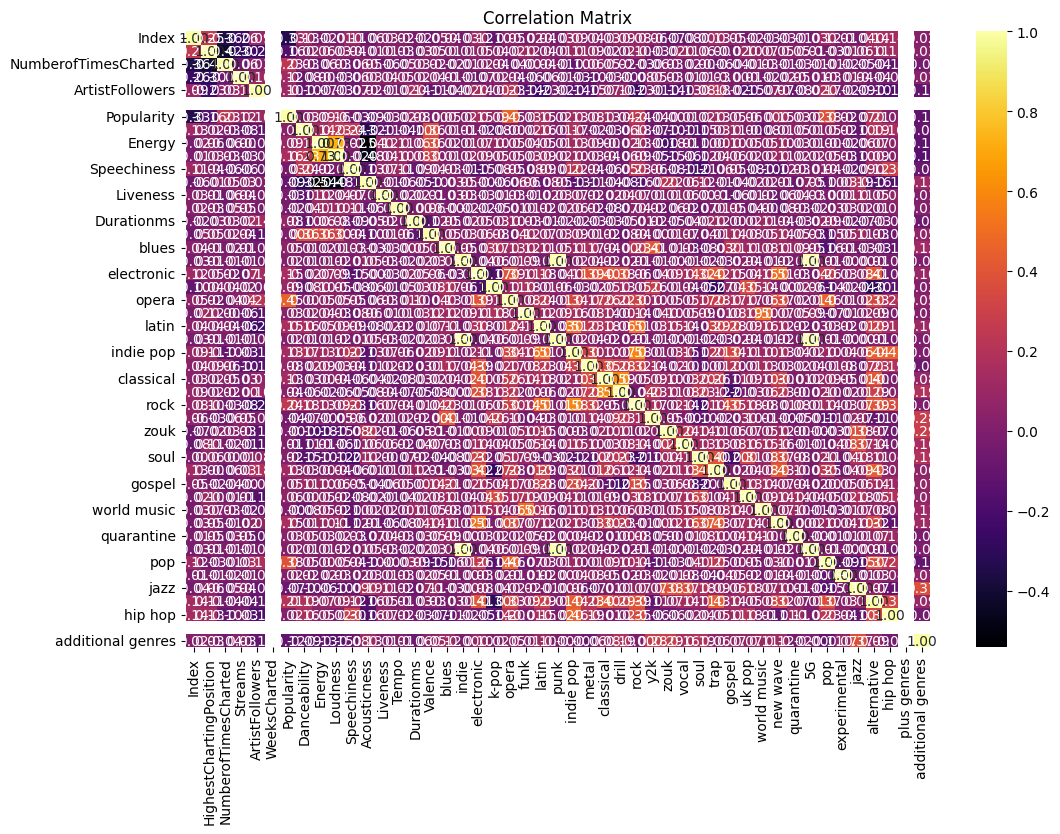

In [241]:
# Drop 'Song Name', 'Artist', and 'Genre' columns before calculating correlations
df_no_song_artist_genre = df_clean.drop(columns=['SongName', 'Artist', 'Genre'])

# Ensure that only numeric columns remain
df_numeric = df_no_song_artist_genre.select_dtypes(include=['float64', 'int64'])

# Calculate and visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='inferno', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix

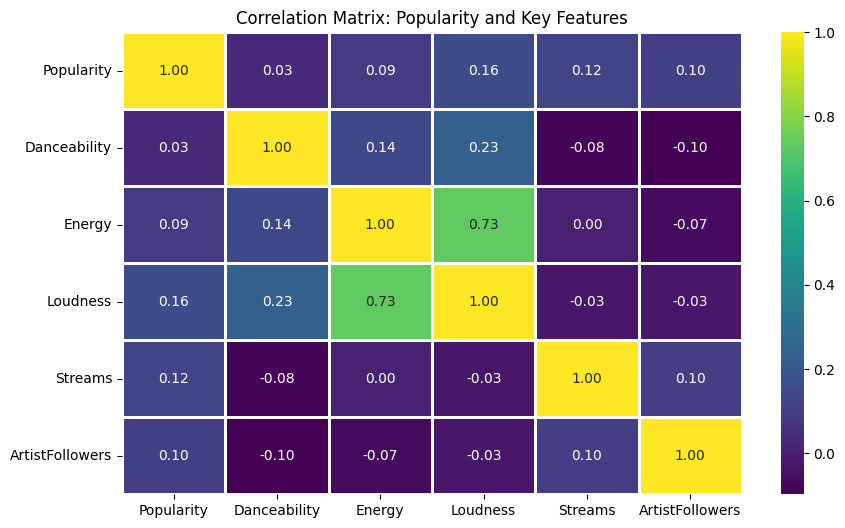

In [242]:
# Visualizing Correlations with Popularity
plt.figure(figsize=(10, 6))
corr_features = df_clean[['Popularity', 'Danceability', 'Energy', 'Loudness', 'Streams', 'ArtistFollowers']]
correlation_matrix = corr_features.corr()

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=1, cbar=True)
plt.title('Correlation Matrix: Popularity and Key Features')
plt.show()

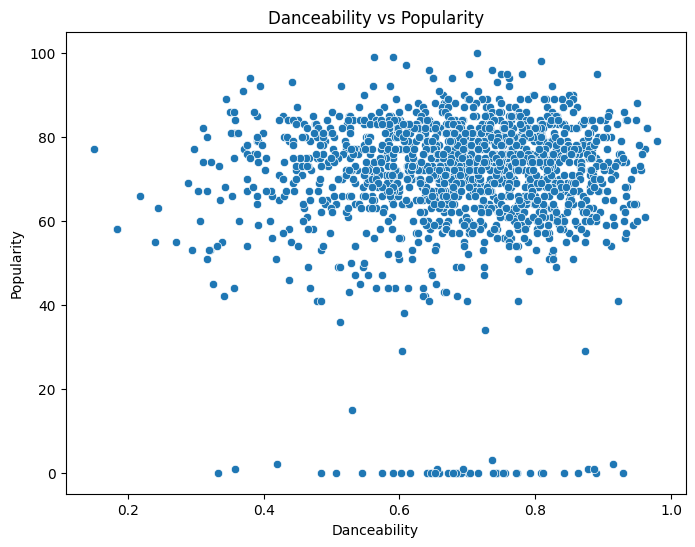

In [243]:
# Scatter plot of Danceability vs Popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Danceability', y='Popularity')
plt.title('Danceability vs Popularity')
plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.show()

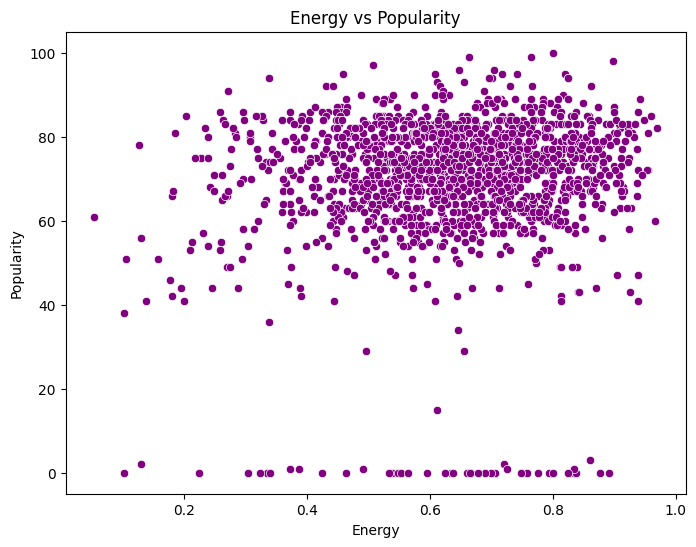

In [244]:
# Scatter plot of Energy vs Popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Energy', y='Popularity', color='purple')
plt.title('Energy vs Popularity')
plt.xlabel('Energy')
plt.ylabel('Popularity')
plt.show()

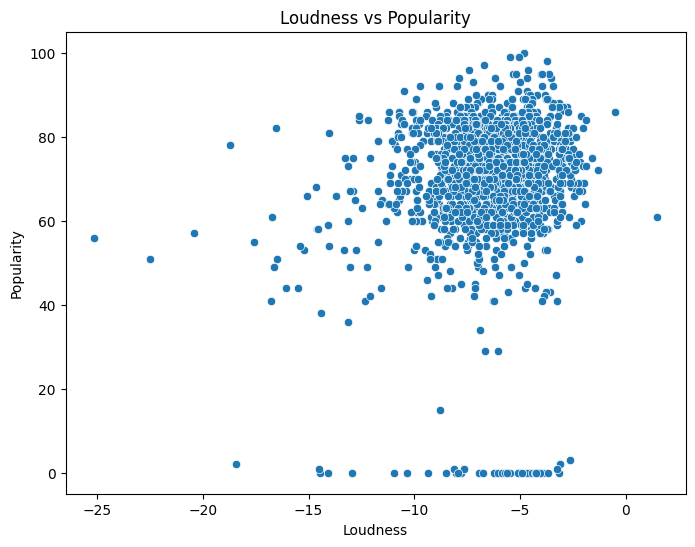

In [245]:
# Scatter plot of Loudness vs Popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Loudness', y='Popularity')
plt.title('Loudness vs Popularity')
plt.xlabel('Loudness')
plt.ylabel('Popularity')
plt.show()

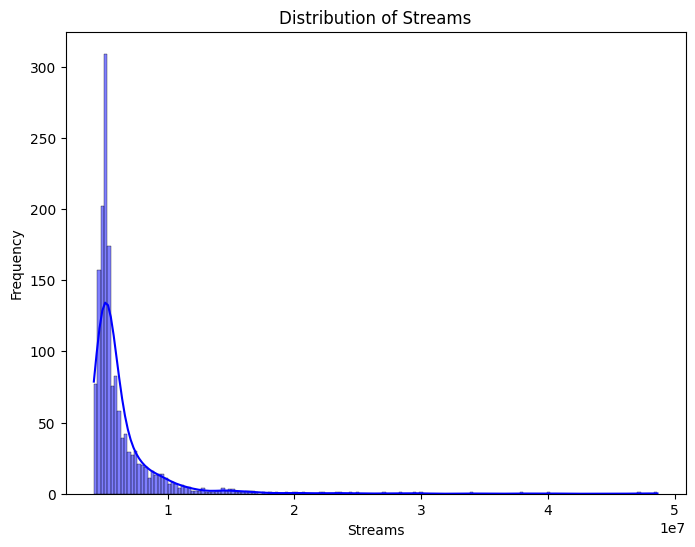

In [246]:
# Distribution of Streams
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['Streams'], kde=True, color='blue')
plt.title('Distribution of Streams')
plt.xlabel('Streams')
plt.ylabel('Frequency')
plt.show()

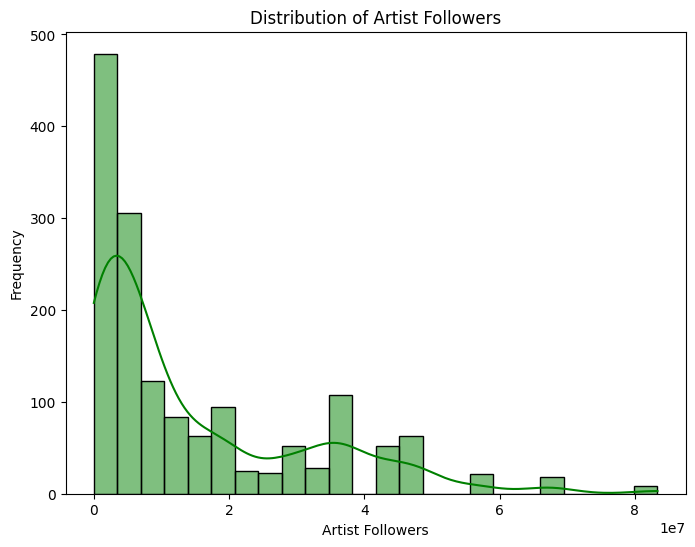

In [247]:
# Distribution of ArtistFollowers
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['ArtistFollowers'], kde=True, color='green')
plt.title('Distribution of Artist Followers')
plt.xlabel('Artist Followers')
plt.ylabel('Frequency')
plt.show()

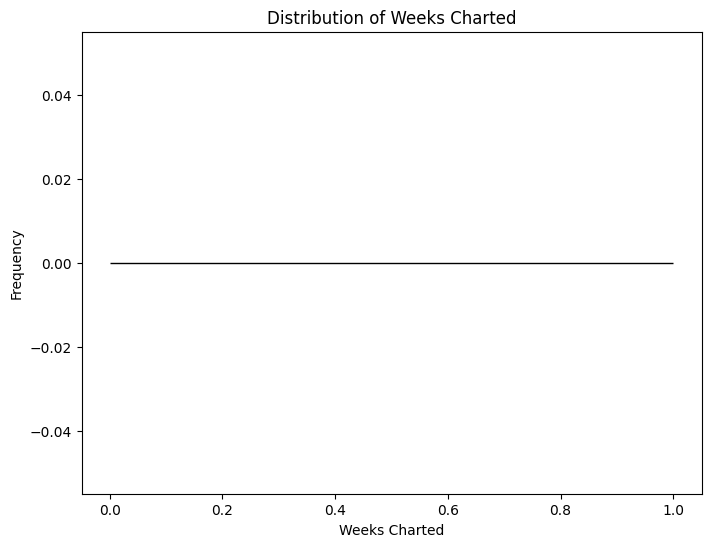

In [248]:
# Distribution of WeeksCharted
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['WeeksCharted'], kde=True, color='purple')
plt.title('Distribution of Weeks Charted')
plt.xlabel('Weeks Charted')
plt.ylabel('Frequency')
plt.show()

In [249]:
# Check unique values and their counts for WeeksCharted
df_clean['WeeksCharted'].value_counts().sort_index()

,count
WeeksCharted,


In [250]:
# Check for missing values in WeeksCharted
df_clean['WeeksCharted'].isnull().sum()

np.int64(1545)

<ipython-input-251-23dd43446c0b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Release Month', y='Popularity', palette='Set2')


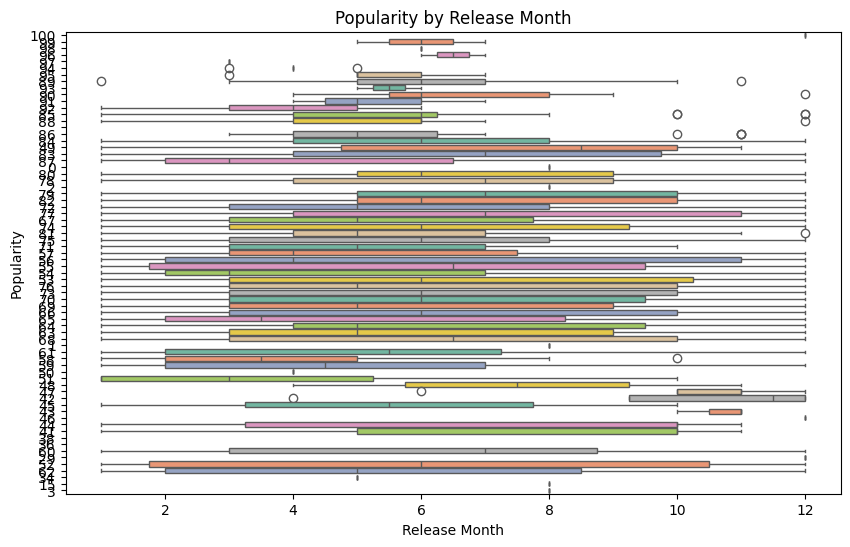

In [251]:
# Extract release month
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Month'] = df['Release Date'].dt.month

# Boxplot by release month
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Release Month', y='Popularity', palette='Set2')
plt.title('Popularity by Release Month')
plt.show()

## Defining Target and Features

In [252]:
# Define target and features
X = df_clean.drop(columns=['Popularity', 'SongName', 'Artist'])  # Exclude the target and non-predictive features
y = df_clean['Popularity']  # Target: Popularity

In [253]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [254]:
df_clean.columns

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres'],
      dtype='object')

In [255]:
# Drop non-numeric columns including 'Song Name', 'Artist', and 'Genre'
X = df_clean.drop(columns=['Popularity', 'SongName', 'Artist', 'Genre'])

# Now X should only contain numeric values (including one-hot encoded genre columns)

# Define target variable y
y = df_clean['Popularity']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model performance (e.g., RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 4.6762164192860025


In [256]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9186838767265747


In [257]:
feature_importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                    Feature    Importance
0                     Index  2.388982e-01
4           ArtistFollowers  2.359325e-01
19                    opera  1.804656e-01
2      NumberofTimesCharted  7.477473e-02
3                   Streams  3.675545e-02
42              alternative  3.514701e-02
27                     rock  3.192736e-02
39                      pop  2.784277e-02
6              Danceability  1.738175e-02
1   HighestChartingPosition  1.443095e-02
9               Speechiness  1.328991e-02
13               Durationms  1.284893e-02
10             Acousticness  1.154738e-02
14                  Valence  1.088776e-02
8                  Loudness  1.036443e-02
11                 Liveness  1.028738e-02
12                    Tempo  8.851589e-03
7                    Energy  6.398590e-03
21                    latin  3.350338e-03
26                    drill  2.488720e-03
45        additional genres  2.205714e-03
31                     soul  1.333856e-03
28                      y2k  1.235

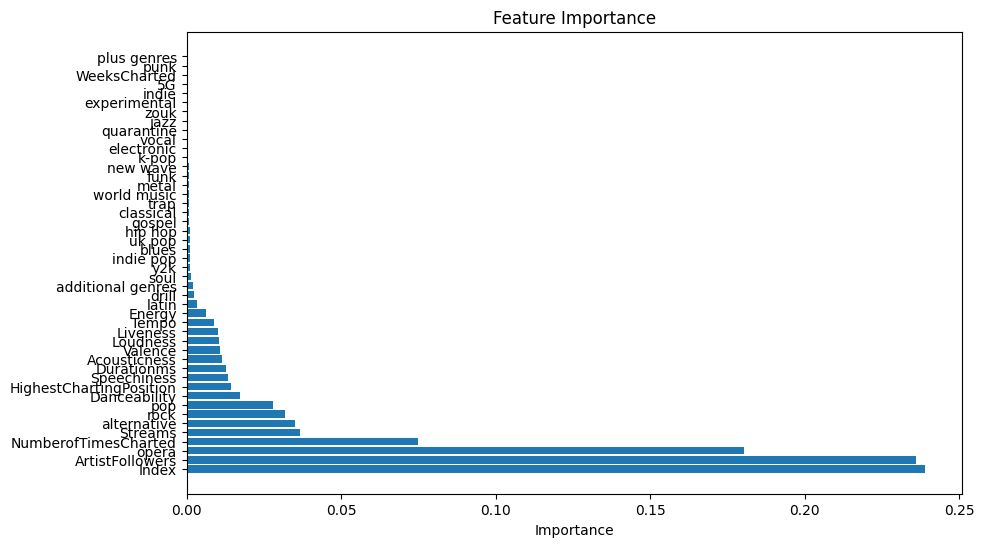

In [258]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

My model wasn't taking into account genres the way I want it to, I'm going to include Group Genres to have this impact the model

In [259]:
genre_mapping = {
    'pop': ['pop', 'italian pop', 'pop rap', 'uk pop'],
    'hip hop': ['australian hip hop', 'lgbtq+ hip hop', 'pop rap'],
    'rock': ['indie rock', 'indie rock italiano'],
    'latin': ['latin', 'reggaeton', 'reggaeton colombiano'],
    'electronic': ['edm', 'house', 'techno', 'electronic'],
    'r&b': ['r&b', 'soul', 'neo soul'],
    'other': []  # for any genres that don't fit into the above categories
}

In [260]:
def group_genres(genre_list, genre_mapping):
    if not isinstance(genre_list, list):
        return ['unknown']
    grouped_genres = set()
    for genre in genre_list:
        for group, genres in genre_mapping.items():
            if genre in genres:
                grouped_genres.add(group)
    return list(grouped_genres) if grouped_genres else ['unknown']

# Apply the grouping
df_clean['GroupedGenre'] = df_clean['Genre'].apply(lambda x: group_genres(x, genre_mapping))

In [261]:
print(df_clean.columns)

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres', 'GroupedGenre'],
      dtype='object')


In [262]:
df_clean_grouped_genres = df_clean.copy()
print(df_clean_grouped_genres.columns)

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres', 'GroupedGenre'],
      dtype='object')


In [263]:
df_clean_grouped_genres['GroupedGenre'] = df_clean_grouped_genres['GroupedGenre'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
)


In [264]:
df_model = pd.get_dummies(df_clean_grouped_genres, columns=['GroupedGenre'], drop_first=True)

In [265]:
print(df_model.columns)

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres'],
      dtype='object')


In [266]:
drop_cols = ['Index', 'SongName', 'Artist', 'Genre', 'plus genres', 'additional genres']
X = df_model.drop(columns=drop_cols + ['Popularity'])
y = df_model['Popularity']

In [267]:
df_model.columns

Index(['Index', 'HighestChartingPosition', 'NumberofTimesCharted', 'SongName',
       'Streams', 'Artist', 'ArtistFollowers', 'Genre', 'WeeksCharted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Durationms', 'Valence', 'blues',
       'indie', 'electronic', 'k-pop', 'opera', 'funk', 'latin', 'punk',
       'indie pop', 'metal', 'classical', 'drill', 'rock', 'y2k', 'zouk',
       'vocal', 'soul', 'trap', 'gospel', 'uk pop', 'world music', 'new wave',
       'quarantine', '5G', 'pop', 'experimental', 'jazz', 'alternative',
       'hip hop', 'plus genres', 'additional genres'],
      dtype='object')

### Perform Random Forest Regressor Model

In [268]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 6.556706073863957


### Cross Validation

In [269]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Perform cross-validation (using negative RMSE since cross_val_score minimizes the score)
scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Convert the negative RMSE to positive and print it
rmse_scores = -scores  # neg_root_mean_squared_error returns negative values
print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Standard deviation of RMSE:", np.std(rmse_scores))


Cross-validated RMSE scores: [14.39307356  8.65874028 13.43991011  5.41721314  8.79557179]
Mean RMSE: 10.140901777568311
Standard deviation of RMSE: 3.3251878329338127


### Visualize Features for Predicting Popularity from our Random Forest Model

In [270]:
# Fit the RandomForestRegressor model
rf_model.fit(X_train, y_train)

# Access the feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame
feat_imp = sorted(zip(importances, feature_names), reverse=True)

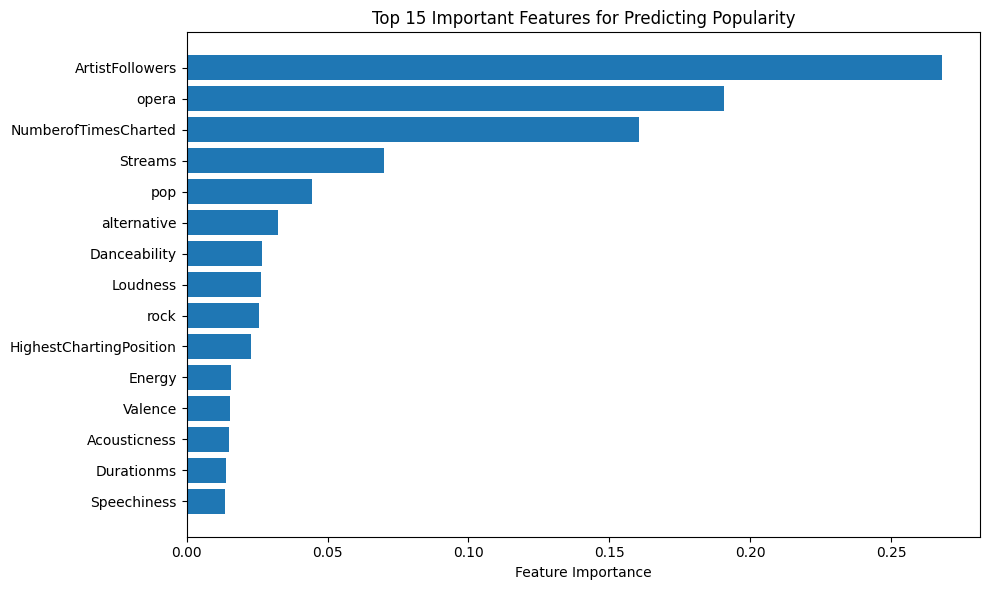

In [271]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = sorted(zip(importances, feature_names), reverse=True)

# Plot top 15 important features
plt.figure(figsize=(10, 6))
plt.barh([f[1] for f in feat_imp[:15]][::-1], [f[0] for f in feat_imp[:15]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features for Predicting Popularity")
plt.tight_layout()
plt.show()

In [272]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Train Model with top 5 Features and compare with Full Model

Top 5 Features Model RMSE: 17.556839923951184
Full Model RMSE: 6.480185756856488
The full model performs better!


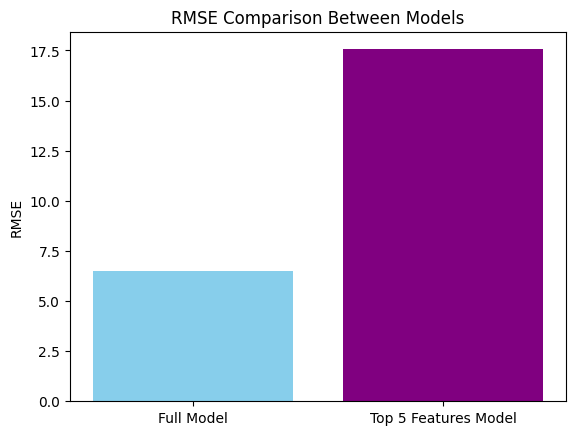

In [273]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define top 5 features
top_5_features = ['Danceability', 'Energy', 'Loudness', 'Tempo', 'Acousticness']

# Select the features for X_train and X_test based on the top 5
X_train_top5 = X_train[top_5_features]
X_test_top5 = X_test[top_5_features]

# Train the model using RandomForestRegressor
rf_top5_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top5_model.fit(X_train_top5, y_train)

# Make predictions with the trained model
y_pred_top5 = rf_top5_model.predict(X_test_top5)

# Calculate RMSE for the top 5 features model
mse_top5 = mean_squared_error(y_test, y_pred_top5)
rmse_top5 = mse_top5 ** 0.5
print("Top 5 Features Model RMSE:", rmse_top5)

# Make predictions for the full model
y_pred_full = rf_model.predict(X_test)  # Assuming rf_model is your full RandomForestRegressor model

# Calculate RMSE for the full model
mse_full = mean_squared_error(y_test, y_pred_full)  # Default squared=True
rmse_full = mse_full ** 0.5
print("Full Model RMSE:", rmse_full)

# Compare the RMSEs
if rmse_top5 < rmse_full:
    print("The top 5 features model performs better!")
else:
    print("The full model performs better!")

# Visualization: Plot the RMSE comparison
model_names = ['Full Model', 'Top 5 Features Model']
rmse_values = [rmse_full, rmse_top5]

plt.bar(model_names, rmse_values, color=['skyblue', 'purple'])
plt.title('RMSE Comparison Between Models')
plt.ylabel('RMSE')
plt.show()

### Comparing Cross-Validated Scores between Models

Full Model Mean RMSE: 10.1070 ± 3.3601
Top 5 Features Model Mean RMSE: 17.0032 ± 2.4056
The full model performs better!


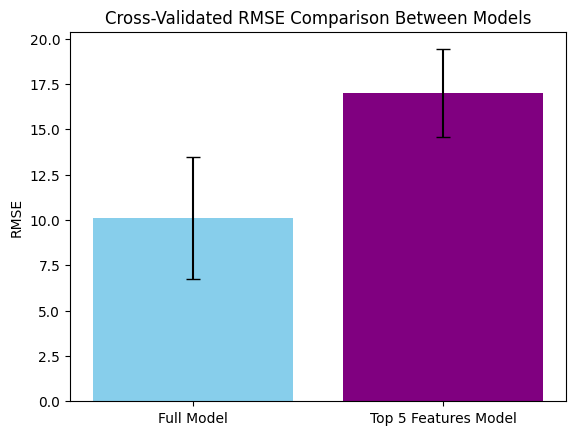

In [274]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define top 5 features
top_5_features = ['Danceability', 'Energy', 'Loudness', 'Tempo', 'Acousticness']

# Select the features for X_train based on the top 5
X_train_top5 = X[top_5_features]

# Create the RandomForestRegressor models
rf_model_full = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top5 = RandomForestRegressor(n_estimators=100, random_state=42)

# Define RMSE scorer using make_scorer
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))

# Perform cross-validation for the full model
cv_full = cross_val_score(rf_model_full, X, y, cv=5, scoring=rmse_scorer)

# Perform cross-validation for the top 5 features model
cv_top5 = cross_val_score(rf_model_top5, X_train_top5, y, cv=5, scoring=rmse_scorer)

# Calculate the mean and standard deviation of RMSE for both models
mean_rmse_full = np.mean(cv_full)
std_rmse_full = np.std(cv_full)

mean_rmse_top5 = np.mean(cv_top5)
std_rmse_top5 = np.std(cv_top5)

# Print the results
print(f"Full Model Mean RMSE: {mean_rmse_full:.4f} ± {std_rmse_full:.4f}")
print(f"Top 5 Features Model Mean RMSE: {mean_rmse_top5:.4f} ± {std_rmse_top5:.4f}")

# Compare the models
if mean_rmse_top5 < mean_rmse_full:
    print("The top 5 features model performs better!")
else:
    print("The full model performs better!")

# Visualization: Plot the RMSE comparison
model_names = ['Full Model', 'Top 5 Features Model']
rmse_values = [mean_rmse_full, mean_rmse_top5]
std_values = [std_rmse_full, std_rmse_top5]

# Create the plot
plt.bar(model_names, rmse_values, yerr=std_values, capsize=5, color=['skyblue', 'purple'])
plt.title('Cross-Validated RMSE Comparison Between Models')
plt.ylabel('RMSE')
plt.show()
